In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# -----------------------------
# 1. Load Data
# -----------------------------
neuro_csv = "results_neuroback_final.csv"
default_csv = "results_default.csv"
mamba_csv = "results_mamba.csv"


neuro = pd.read_csv(neuro_csv)
default = pd.read_csv(default_csv)
mamba = pd.read_csv(mamba_csv)

# Rename Mamba columns
mamba = mamba.rename(columns={
    "solving_time_sec": "solving_time_sec_mamba",
    "result": "result_mamba"
})

# -----------------------------
# 2. Merge DataFrames
# -----------------------------
merged = neuro.merge(default, on="cnf_name", suffixes=("_neuro", "_default"))
merged = merged.merge(mamba, on="cnf_name")
print("Total merged rows:", len(merged))
merged.head()

Total merged rows: 1898


,cnf_name,solver_neuro,result_neuro,solving_time_sec_neuro,inference_time_sec_neuro,has_backbone_neuro,n_vars_neuro,n_clauses_neuro,solver_default,result_default,...,has_backbone_default,n_vars_default,n_clauses_default,solver,result_mamba,solving_time_sec_mamba,inference_time_sec,has_backbone,n_vars,n_clauses
0,3_105_398.cnf.xz,NeuroBack,"SATISFIABLE,0",0.001870,0.0,True,105,398,Default,"SATISFIABLE,0",...,NaN,105,398,mamba,"SATISFIABLE,0",0.001866,0.0,True,105,398
1,3_112_419.cnf.xz,NeuroBack,"SATISFIABLE,0",0.001515,0.0,True,112,419,Default,"SATISFIABLE,0",...,NaN,112,419,mamba,"SATISFIABLE,0",0.000928,0.0,True,112,419
2,3_112_442.cnf.xz,NeuroBack,"SATISFIABLE,0",0.002093,0.0,True,112,442,Default,"SATISFIABLE,0",...,NaN,112,442,mamba,"SATISFIABLE,0",0.002263,0.0,True,112,442
3,3_117_432.cnf.xz,NeuroBack,"SATISFIABLE,0",0.002627,0.0,True,117,432,Default,"SATISFIABLE,0",...,NaN,117,432,mamba,"SATISFIABLE,0",0.003469,0.0,True,117,432
4,3_118_471.cnf.xz,NeuroBack,"SATISFIABLE,0",0.001656,0.0,True,118,471,Default,"SATISFIABLE,0",...,NaN,118,471,mamba,"SATISFIABLE,0",0.001523,0.0,True,118,471


In [4]:
# -----------------------------
# 3. Cleaning and Filtering (UPDATED LOGIC)
# -----------------------------

def clean_result_column(series):
    """Cleans the result column by extracting only the main label."""
    return series.astype(str).str.strip().str.upper().str.split(',').str[0]

# Apply the cleaning logic
merged["result_neuro"] = clean_result_column(merged["result_neuro"])
merged["result_default"] = clean_result_column(merged["result_default"])
merged["result_mamba"] = clean_result_column(merged["result_mamba"])

# Mapping to standard solved labels
SOLVED_LABELS = ["SATISFIABLE", "UNSATISFIABLE"]

# Inicialmente, filtramos solo los resueltos correctamente por todos
mask_ok_neuro = merged["result_neuro"].isin(SOLVED_LABELS)
mask_ok_default = merged["result_default"].isin(SOLVED_LABELS)
mask_ok_mamba = merged["result_mamba"].isin(SOLVED_LABELS)

merged_clean = merged[mask_ok_neuro & mask_ok_default & mask_ok_mamba].copy()
print("Clean rows (solved by all 3, initial):", len(merged_clean))

# -----------------------------
merged_clean.head()

Clean rows (solved by all 3, initial): 1869


,cnf_name,solver_neuro,result_neuro,solving_time_sec_neuro,inference_time_sec_neuro,has_backbone_neuro,n_vars_neuro,n_clauses_neuro,solver_default,result_default,...,has_backbone_default,n_vars_default,n_clauses_default,solver,result_mamba,solving_time_sec_mamba,inference_time_sec,has_backbone,n_vars,n_clauses
0,3_105_398.cnf.xz,NeuroBack,SATISFIABLE,0.001870,0.0,True,105,398,Default,SATISFIABLE,...,NaN,105,398,mamba,SATISFIABLE,0.001866,0.0,True,105,398
1,3_112_419.cnf.xz,NeuroBack,SATISFIABLE,0.001515,0.0,True,112,419,Default,SATISFIABLE,...,NaN,112,419,mamba,SATISFIABLE,0.000928,0.0,True,112,419
2,3_112_442.cnf.xz,NeuroBack,SATISFIABLE,0.002093,0.0,True,112,442,Default,SATISFIABLE,...,NaN,112,442,mamba,SATISFIABLE,0.002263,0.0,True,112,442
3,3_117_432.cnf.xz,NeuroBack,SATISFIABLE,0.002627,0.0,True,117,432,Default,SATISFIABLE,...,NaN,117,432,mamba,SATISFIABLE,0.003469,0.0,True,117,432
4,3_118_471.cnf.xz,NeuroBack,SATISFIABLE,0.001656,0.0,True,118,471,Default,SATISFIABLE,...,NaN,118,471,mamba,SATISFIABLE,0.001523,0.0,True,118,471


In [5]:

# -----------------------------
# 4. Outlier Filtering (< 5 seconds)
# -----------------------------
TIME_THRESHOLD = 5

# Máscara de outliers: si CUALQUIER tiempo es mayor al umbral
mask_outlier = (merged_clean["solving_time_sec_neuro"] > TIME_THRESHOLD) | \
               (merged_clean["solving_time_sec_default"] > TIME_THRESHOLD) | \
               (merged_clean["solving_time_sec_mamba"] > TIME_THRESHOLD)

# Aplicar filtro: mantén solo los que NO son outliers
merged_ultra_clean = merged_clean[~mask_outlier].copy()
print(f"Ultra Clean rows (Time < {TIME_THRESHOLD}s):", len(merged_ultra_clean))

# -----------------------------
merged_ultra_clean.head()

Ultra Clean rows (Time < 5s): 1864


,cnf_name,solver_neuro,result_neuro,solving_time_sec_neuro,inference_time_sec_neuro,has_backbone_neuro,n_vars_neuro,n_clauses_neuro,solver_default,result_default,...,has_backbone_default,n_vars_default,n_clauses_default,solver,result_mamba,solving_time_sec_mamba,inference_time_sec,has_backbone,n_vars,n_clauses
0,3_105_398.cnf.xz,NeuroBack,SATISFIABLE,0.001870,0.0,True,105,398,Default,SATISFIABLE,...,NaN,105,398,mamba,SATISFIABLE,0.001866,0.0,True,105,398
1,3_112_419.cnf.xz,NeuroBack,SATISFIABLE,0.001515,0.0,True,112,419,Default,SATISFIABLE,...,NaN,112,419,mamba,SATISFIABLE,0.000928,0.0,True,112,419
2,3_112_442.cnf.xz,NeuroBack,SATISFIABLE,0.002093,0.0,True,112,442,Default,SATISFIABLE,...,NaN,112,442,mamba,SATISFIABLE,0.002263,0.0,True,112,442
3,3_117_432.cnf.xz,NeuroBack,SATISFIABLE,0.002627,0.0,True,117,432,Default,SATISFIABLE,...,NaN,117,432,mamba,SATISFIABLE,0.003469,0.0,True,117,432
4,3_118_471.cnf.xz,NeuroBack,SATISFIABLE,0.001656,0.0,True,118,471,Default,SATISFIABLE,...,NaN,118,471,mamba,SATISFIABLE,0.001523,0.0,True,118,471



--- Segmented Performance Analysis (Mamba vs NeuroBack) ---
Total instances analyzed (Time <= 10.0s): 1869
| time_segment        |   Count | Mean Speedup   | Median Speedup   | Mamba Win Rate (%)   |
|:--------------------|--------:|:---------------|:-----------------|:---------------------|
| Very Fast (<= 0.1s) |    1811 | 1.0160x        | 1.0148x          | 44.45%               |
| Fast (0.1s - 1s)    |      42 | 1.0014x        | 0.9998x          | 50.00%               |
| Long (1s - 10s)     |      16 | 0.9982x        | 0.9963x          | 50.00%               |


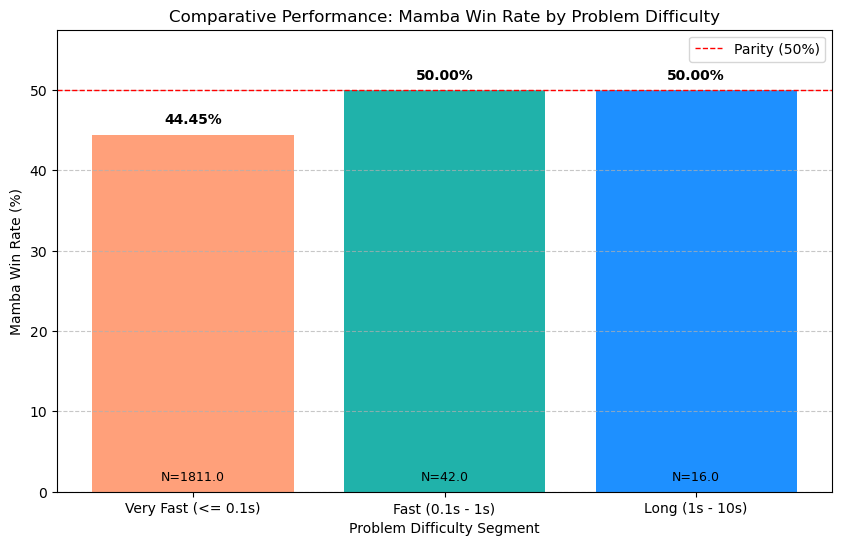

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume the DataFrame 'merged_clean' is already created.
df_original = merged_clean.copy()

# -----------------------------
# TIME SEGMENT DEFINITION
# -----------------------------
TIME_LIMIT = 10.0 # Total limit
# BINS: [0.0 - 0.1s], [0.1s - 1.0s], [1.0s - 10.0s]
BINS = [0.0, 0.1, 1.0, TIME_LIMIT] 
LABELS = ['Very Fast (<= 0.1s)', 'Fast (0.1s - 1s)', 'Long (1s - 10s)'] # Labels updated to reflect 10s limit

# Initial filtering mask (both solve within 10s)
mask_time = (df_original["solving_time_sec_neuro"] <= TIME_LIMIT) & \
            (df_original["solving_time_sec_mamba"] <= TIME_LIMIT)
df_filtered = df_original[mask_time].copy()

# Create a temporary column that takes the MAXIMUM time between Neuro and Mamba (to classify difficulty)
df_filtered['max_time'] = df_filtered[['solving_time_sec_neuro', 'solving_time_sec_mamba']].max(axis=1)

# Create the segment column based on the BINS
df_filtered['time_segment'] = pd.cut(df_filtered['max_time'], bins=BINS, labels=LABELS, right=True, include_lowest=True)

# -----------------------------
# METRICS CALCULATION PER SEGMENT
# -----------------------------

def analyze_segment(segment_df):
    if len(segment_df) == 0:
        return pd.Series([0, np.nan, np.nan, np.nan], 
                         index=['Count', 'Mean Speedup', 'Median Speedup', 'Mamba Win Rate (%)'])
    
    # Calculate Speedup (Mamba Time / Neuro Time)
    speedup = segment_df["solving_time_sec_mamba"] / segment_df["solving_time_sec_neuro"].replace(0, np.nan)
    
    # Mamba Win Rate (Mamba Time < Neuro Time)
    mamba_win_rate = (segment_df["solving_time_sec_mamba"] < segment_df["solving_time_sec_neuro"]).mean() * 100
    
    return pd.Series([
        len(segment_df),
        speedup.mean(),
        speedup.median(),
        mamba_win_rate
    ], index=['Count', 'Mean Speedup', 'Median Speedup', 'Mamba Win Rate (%)'])

# Group and apply the analysis function
# NOTE: Using include_groups=False to silence FutureWarning for newer pandas versions
segment_analysis = df_filtered.groupby('time_segment', observed=False).apply(analyze_segment, include_groups=False).reset_index()

# -----------------------------
# DISPLAY RESULTS
# -----------------------------

print("\n--- Segmented Performance Analysis (Mamba vs NeuroBack) ---")
print(f"Total instances analyzed (Time <= {TIME_LIMIT}s): {len(df_filtered)}")

# Format the table
segment_analysis['Mean Speedup'] = segment_analysis['Mean Speedup'].map('{:.4f}x'.format)
segment_analysis['Median Speedup'] = segment_analysis['Median Speedup'].map('{:.4f}x'.format)
segment_analysis['Mamba Win Rate (%)'] = segment_analysis['Mamba Win Rate (%)'].map('{:.2f}%'.format)

print(segment_analysis.to_markdown(index=False))

# -----------------------------
# PLOTTING FUNCTION (Comparative Segment Plot)
# -----------------------------

def plot_segment_analysis(analysis_df):
    """Generates a bar plot comparing Mamba's Win Rate across time segments."""
    
    # Extract data for plotting
    win_rates = analysis_df['Mamba Win Rate (%)'].str.replace('%', '').str.replace('x', '').astype(float)
    segments = analysis_df['time_segment']
    counts = analysis_df['Count']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(segments, win_rates, color=['#FFA07A', '#20B2AA', '#1E90FF'])
    
    # Draw Parity line (50%)
    plt.axhline(50, color='red', linestyle='--', linewidth=1, label='Parity (50%)')
    
    # Add text labels (Win Rate and Count) above bars
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        # Win Rate
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', 
                 ha='center', va='bottom', fontweight='bold')
        # Instance Count
        plt.text(bar.get_x() + bar.get_width()/2, 1, f'N={counts.iloc[i]}', 
                 ha='center', va='bottom', color='black', fontsize=9)
    
    plt.ylim(0, win_rates.max() * 1.15 if not win_rates.empty else 60)
    plt.xlabel("Problem Difficulty Segment")
    plt.ylabel("Mamba Win Rate (%)")
    plt.title("Comparative Performance: Mamba Win Rate by Problem Difficulty")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# -----------------------------
# EXECUTE PLOTTING
# -----------------------------
plot_segment_analysis(segment_analysis)

Instancias después de filtrar por tiempo (< 1s): 1853


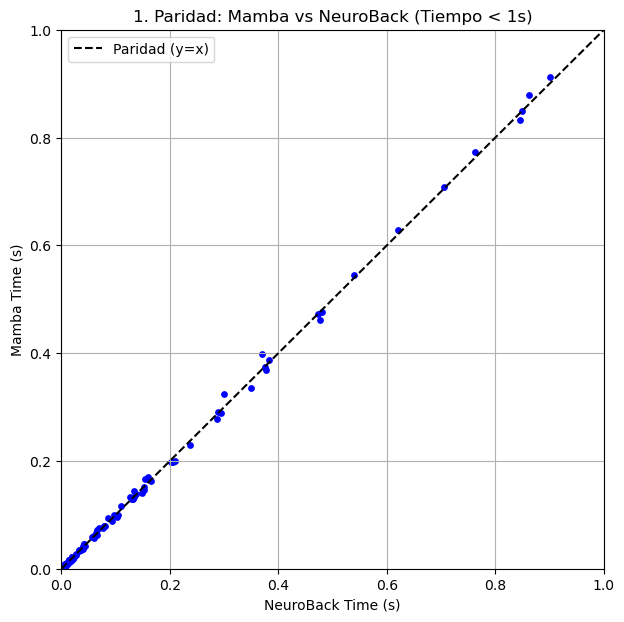


--- Análisis Cuantitativo (Mamba vs NeuroBack) ---
Número total de instancias comparadas: 1853
Speedup Promedio (Mamba Time / Neuro Time): 1.0156x
Speedup Mediano (Mamba Time / Neuro Time): 1.0137x
Mamba es más rápido en el 44.58% de las instancias.


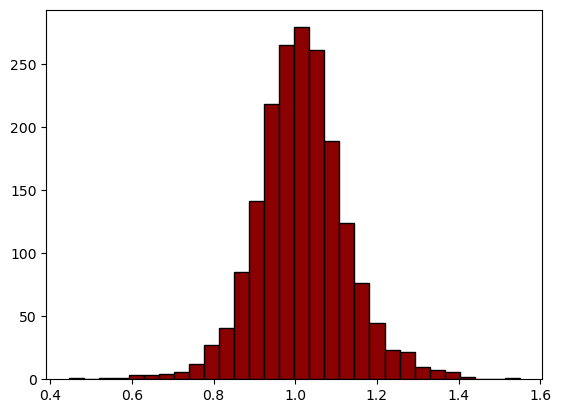

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asumimos que el DataFrame 'merged_clean' ya fue creado y contiene los datos limpios.
df_original = merged_clean.copy()

# -----------------------------
# NUEVO FILTRO DE TIEMPO
# -----------------------------
TIME_LIMIT = 1 # Define el nuevo límite de tiempo (1 segundo)

mask_time = (df_original["solving_time_sec_neuro"] <= TIME_LIMIT) & \
            (df_original["solving_time_sec_mamba"] <= TIME_LIMIT)

df = df_original[mask_time].copy()
print(f"Instancias después de filtrar por tiempo (< {TIME_LIMIT}s): {len(df)}")
# -----------------------------

# Calcular Speedup de Mamba vs NeuroBack (Mamba_time / Neuro_time)
df["speedup_mamba_neuro"] = df["solving_time_sec_mamba"] / df["solving_time_sec_neuro"].replace(0, np.nan) 

# -------------------------------------------------------
# 1. Generar Gráfico de Paridad INVERTIDO (FILTRADO)
# -------------------------------------------------------

time_neuro = df["solving_time_sec_neuro"]
time_mamba = df["solving_time_sec_mamba"]

plt.figure(figsize=(7, 7))

# TRAZADO INVERTIDO: Mamba Time (Y) vs NeuroBack Time (X)
plt.scatter(time_neuro, time_mamba, alpha=1, s=15, color='blue')

# Línea de identidad (y=x)
# Usamos el límite de tiempo del filtro para el máximo valor
max_t_plot = TIME_LIMIT
plt.plot([0, max_t_plot], [0, max_t_plot], 'k--', label="Paridad (y=x)") 

# Añadir títulos y etiquetas
plt.xlabel("NeuroBack Time (s)")
plt.ylabel("Mamba Time (s)")
plt.title(f"1. Paridad: Mamba vs NeuroBack (Tiempo < {TIME_LIMIT}s)")
plt.legend()
plt.grid(True)
# Configuramos el límite del plot al filtro de tiempo
plt.xlim(0, max_t_plot)
plt.ylim(0, max_t_plot)
plt.show()

# -------------------------------------------------------
# 2. Histograma de Speedup (FILTRADO)
# -------------------------------------------------------

speedup_mamba_neuro = df["speedup_mamba_neuro"]
# El Speedup de Mamba vs NeuroBack, un valor < 1 significa que Mamba es más rápido.
plt.hist(speedup_mamba_neuro.dropna(), bins=30, color='darkred', edgecolor='black')
median_speedup = speedup_mamba_neuro.median()


# -------------------------------------------------------
# 3. Análisis de Diferencia Cuantitativa (FILTRADO)
# -------------------------------------------------------

mamba_win_rate = (time_mamba < time_neuro).mean() * 100
mean_speedup = speedup_mamba_neuro.mean()

print("\n--- Análisis Cuantitativo (Mamba vs NeuroBack) ---")
print(f"Número total de instancias comparadas: {len(df)}")
print(f"Speedup Promedio (Mamba Time / Neuro Time): {mean_speedup:.4f}x")
print(f"Speedup Mediano (Mamba Time / Neuro Time): {median_speedup:.4f}x")
print(f"Mamba es más rápido en el {mamba_win_rate:.2f}% de las instancias.")

In [8]:
import numpy as np
import pandas as pd

# Asumimos que el DataFrame 'merged' ya existe y tiene las columnas limpiadas
# (ej., result_neuro, solving_time_sec_neuro, etc.)

# -----------------------------
# 4. Outlier Filtering (< 5 seconds)
# -----------------------------
TIME_THRESHOLD = 5.0 # Usamos float por consistencia

# Máscara de outliers: si CUALQUIER tiempo es mayor al umbral
mask_outlier = (merged_clean["solving_time_sec_neuro"] > TIME_THRESHOLD) | \
               (merged_clean["solving_time_sec_default"] > TIME_THRESHOLD) | \
               (merged_clean["solving_time_sec_mamba"] > TIME_THRESHOLD)

# Aplicar filtro: mantén solo los que NO son outliers
merged_ultra_clean = merged_clean[~mask_outlier].copy()
print(f"Ultra Clean rows (Time < {TIME_THRESHOLD}s):", len(merged_ultra_clean))

# -----------------------------
# GENERAR CUADRO RESUMEN GLOBAL
# -----------------------------

# Definimos las columnas de tiempo y resultado
SOLVERS = ['neuro', 'default', 'mamba']
SOLVER_LABELS = ['NeuroBack', 'Default', 'Mamba']

# Calcular métricas para el cuadro resumen usando el DataFrame merged_clean
data = {}
for solver, label in zip(SOLVERS, SOLVER_LABELS):
    time_col = f"solving_time_sec_{solver}"
    result_col = f"result_{solver}"
    
    # Filtramos por instancias resueltas (SATISFIABLE o UNSATISFIABLE)
    mask_solved = merged[result_col].isin(["SATISFIABLE", "UNSATISFIABLE"])
    
    # Calcular Speedup vs Default (solo si el solver no es Default)
    speedup = np.nan
    if solver != 'default':
        # Speedup (Default Time / Solver Time) calculado sobre las instancias resueltas por el Solver
        speedup_raw = merged[f"solving_time_sec_default"] / merged[time_col].replace(0, np.nan)
        speedup = speedup_raw[mask_solved].median()

    data[label] = {
        'Total Solved': sum(mask_solved),
        'Mean Time (Solved)': merged.loc[mask_solved, time_col].mean(),
        'Median Time (Solved)': merged.loc[mask_solved, time_col].median(),
        'Median Speedup vs Default': speedup,
        'Max Time (Solved)': merged.loc[mask_solved, time_col].max(),
        'Unsolved/Error': len(merged) - sum(mask_solved)
    }

# Crear el DataFrame resumen
summary_df = pd.DataFrame(data).T

# Formatear la salida para mostrar pocos decimales en tiempos y speedups
summary_df['Mean Time (Solved)'] = summary_df['Mean Time (Solved)'].map('{:.4f}s'.format)
summary_df['Median Time (Solved)'] = summary_df['Median Time (Solved)'].map('{:.4f}s'.format)
summary_df['Max Time (Solved)'] = summary_df['Max Time (Solved)'].map('{:.2f}s'.format)
summary_df['Median Speedup vs Default'] = summary_df['Median Speedup vs Default'].map(lambda x: f'{x:.3f}x' if pd.notna(x) else 'N/A')

print("\n--- Cuadro Resumen Global de Solucionadores ---")
print(summary_df.to_markdown())

# -----------------------------
# Mostrar head del DataFrame ultra limpio
# -----------------------------
print("\nHead del DataFrame Ultra Limpio (filtrado por tiempo):")
print(merged_ultra_clean.head())

Ultra Clean rows (Time < 5.0s): 1864

--- Cuadro Resumen Global de Solucionadores ---
|           |   Total Solved | Mean Time (Solved)   | Median Time (Solved)   | Median Speedup vs Default   | Max Time (Solved)   |   Unsolved/Error |
|:----------|---------------:|:---------------------|:-----------------------|:----------------------------|:--------------------|-----------------:|
| NeuroBack |           1869 | 0.0382s              | 0.0023s                | 0.883x                      | 9.12s               |               29 |
| Default   |           1898 | 0.0393s              | 0.0020s                | N/A                         | 13.79s              |                0 |
| Mamba     |           1869 | 0.0380s              | 0.0023s                | 0.873x                      | 8.99s               |               29 |

Head del DataFrame Ultra Limpio (filtrado por tiempo):
           cnf_name solver_neuro result_neuro  solving_time_sec_neuro  \
0  3_105_398.cnf.xz    NeuroBack  S